In [90]:
import pandas as pd
from  decouple import Config,RepositoryEnv


#Set API Keys and File_path
config = Config(RepositoryEnv(".env"))
file_path = "/Users/jacobfletcher/git/churn_project/data/lg_selected_features.csv"

# sklearn Model Trainer Class

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import comet_ml
import logging
import matplotlib.pyplot as plt


class SklearnModelTrainer:
    def __init__(self, model_name,model, feature_columns, file_path,logging=True) -> None:
        self.model_name = model_name
        self.model = model
        self.experiment = None
        self.file_path = file_path
        self.df  = pd.read_csv(file_path) 
        self.feature_columns = feature_columns
        self.logging = logging
        self.init_logging()
    
    def model_data_prep(self):
        for col_name in self.df.columns:
            try:
                self.feature_columns.index(col_name)
            except ValueError:
                logging.warning(f"{col_name} feature is being dropped")
                self.df = self.df.drop([col_name], axis=1)

        self.df = self.df.fillna(0)
        return self 
    
    def init_logging(self):
        logging.basicConfig(level=logging.INFO)
        logger = logging.getLogger(__name__)
        logger.info("Logging initialized.")

    def iniate_comet(self):
        if self.logging == True:
            self.experiment = comet_ml.Experiment(
                api_key=config("COMET_API"),
                project_name=config("PROJECT_NAME"),
                workspace=config("WORKSPACE"),
            )
        return self

    def normalize_dataframe(self,df, columns_to_normalize=None):
        if columns_to_normalize is None:
            columns_to_normalize = df.select_dtypes(
                include=["float64", "int64"]
            ).columns.tolist()

        scaler = MinMaxScaler()
        df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

        return df
    

    def plot_conf_matrix(self, y_test, y_pred):
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

        # Create a new figure for each plot
        fig, ax = plt.subplots()
        disp.plot(ax=ax)
        
        # Set the title for the entire figure
        fig.suptitle(f"Confusion Matrix - {self.model_name}", fontsize=16)

        # Show the figure
        plt.show()


    def score_metrics(self, y_pred, y_test):
        f1 = f1_score(y_pred=y_pred, y_true=y_test)
        precision = precision_score(y_pred=y_pred, y_true=y_test)
        recall = recall_score(y_pred=y_pred, y_true=y_test)
        metrics = {"f1": f1, "recall": recall, "precision": precision}

        return metrics

    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(
           self.df.drop("label", axis=1), self.df["label"], train_size=0.8, random_state=42
        )
        return X_train, X_test, y_train, y_test

    def build_params(self):
        params = {
            "model_name": self.model_name,
            "model": self.model,
            "model_params": self.model.get_params(),
            "features": self.df.columns,
            "data_source": self.file_path,  # Use self.file_path
        }
        return params

    def comet_logger(self, metrics, y_test, y_pred):
        self.experiment.log_metrics(metrics)
        self.experiment.log_parameters(self.build_params())

        self.experiment.log_confusion_matrix(
            y_true=y_test.tolist(),
            y_predicted=y_pred.tolist(),
            step=0,
            title="Confusion Matrix",
            file_name="confusion-matrix-%03d.json" % 0,
        )

    def train_and_predict(self):
        self.model_data_prep()
        X_train, X_test, y_train, y_test = self.split_data()
        X_train = self.normalize_dataframe(X_train)
        X_test = self.normalize_dataframe(X_test)
        self.model.fit(X_train, y_train)
        y_pred = self.model.predict(X_test)

        return y_pred, y_test, self.model
    
    def evaluate_and_log_metrics(self, y_pred, y_test):
        self.metrics = self.score_metrics(y_pred=y_pred, y_test=y_test)
        #self.plot_conf_matrix(y_pred=y_pred, y_test=y_test)
        if self.logging == True:
            self.comet_logger(
                metrics=self.metrics,
                y_test=y_test,
                y_pred=y_pred
            )
            
            self.experiment.end()
        return self.metrics

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

trainer_plan = {
    "model":{
    "LogisticRegression": LogisticRegression(
        class_weight="balanced", solver="liblinear", random_state=42
    ),
    "RandomForestClassifier": RandomForestClassifier(
        n_estimators=300, max_depth=25, min_samples_split=2, random_state=42
    ),
    "GradientBoostingClassifier": GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),
    "SupportVectorClassifier": SVC(C=1.0, kernel="rbf", gamma="scale", random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=5, weights="uniform", algorithm="auto"),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=50,
        learning_rate=1.0,
        random_state=42,
    ),
    "BaggingClassifier": BaggingClassifier(
        base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42
    ),
    "Gaussian_Naive_Bayes": GaussianNB(),
},
"feature_columns":['label', 'avg(daily_listens)', 'level_flag',
       'pos_interactions', 'neg_interactions', 'unique_locations',
       'distinct_artist', 'About', 'Add Friend', 'Add to Playlist',
       'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'Roll Advert',
       'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade',
       'Thumbs Down', 'Thumbs Up', 'Upgrade']



}


In [93]:
def model_run(model_name, model,feature_columns,file_path, logging):
    model_trainer = SklearnModelTrainer(model_name, model,feature_columns, file_path, logging)
    model_trainer.iniate_comet()
    y_pred, y_test, trained_model = model_trainer.train_and_predict()
    metrics = model_trainer.evaluate_and_log_metrics(y_pred, y_test)
    return metrics,model_trainer


# Build Dict for Quick Preforance Review
performance = {}
# Iterate through Model in Model plan
for model_name in trainer_plan["model"]:
    metrics,model_trainer = model_run(
        model_name=model_name,
        model=trainer_plan["model"][model_name],
        feature_columns=trainer_plan["feature_columns"],
        file_path=file_path,
        logging=False,
    )
    performance[model_name] = metrics

INFO:__main__:Logging initialized.
INFO:__main__:Logging initialized.
INFO:__main__:Logging initialized.
INFO:__main__:Logging initialized.
/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:__main__:Logging initialized.
INFO:__main__:Logging initialized.
INFO:__main__:Logging initialized.
/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
INFO:__main__:Logging initialized.
/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `

In [94]:
  
df = pd.DataFrame.from_dict(performance, orient='index')
df.sort_values('f1', ascending=False)


,f1,recall,precision
Gaussian_Naive_Bayes,0.500000,1.0,0.333333
LogisticRegression,0.486486,0.9,0.333333
AdaBoostClassifier,0.454545,0.5,0.416667
DecisionTreeClassifier,0.181818,0.2,0.166667
GradientBoostingClassifier,0.117647,0.1,0.142857
RandomForestClassifier,0.000000,0.0,0.000000
SupportVectorClassifier,0.000000,0.0,0.000000
KNeighborsClassifier,0.000000,0.0,0.000000
BaggingClassifier,0.000000,0.0,0.000000


## Feature Importance

In [39]:
import numpy as np
model_name = df.index[0]


metrics,model_trainer = model_run(
        model_name=model_name,
        model=trainer_plan["model"][model_name],
        feature_columns=trainer_plan["feature_columns"],
        file_path=file_path,
        logging=False,
    )



INFO:__main__:Logging initialized.


In [40]:

coefficients = model_trainer.model.coef_[0]
features = model_trainer.feature_columns
features.remove("label")

<Axes: ylabel='Feature'>

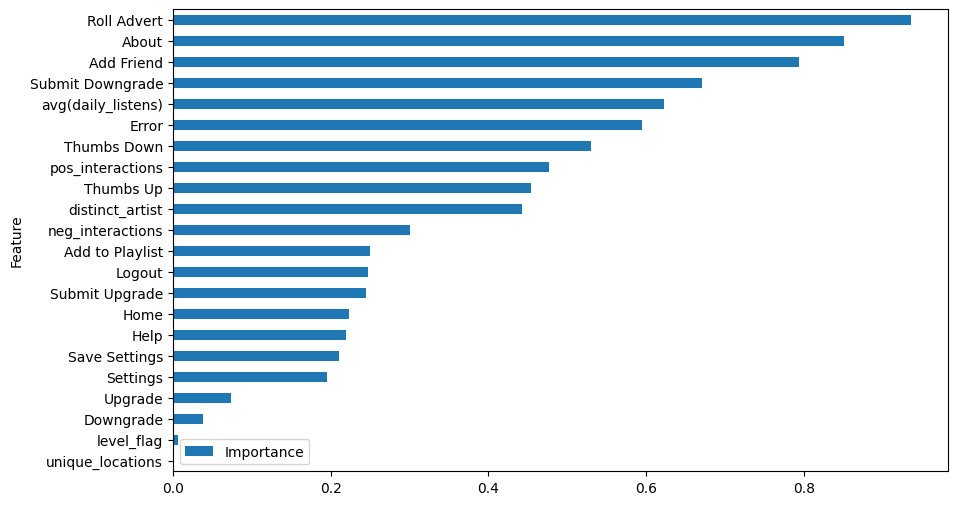

In [41]:

feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

## H2O Linear Model

In [49]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 mins 56 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_jacobfletcher_3l86vb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.000 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [88]:
h2o_df = h2o.import_file(file_path)

# Split the data into training and validation sets
train, valid = h2o_df.split_frame(ratios=[0.85], seed=42)

# Define hyperparameter grid
hyperparams = {
    'alpha': [0.1, 0.5, 0.9],
    'lambda': [1e-5, 1e-6, 1e-7]
}

# Initialize the linear regression model
linear_reg = H2OGeneralizedLinearEstimator(family='binomial')

# Perform grid search
grid_search = H2OGridSearch(linear_reg, hyperparams)
grid_search.train(y="label", training_frame=train)

# Get the best model from the grid search
best_model = grid_search.get_grid()[0]

# Make predictions on the validation set
preds = best_model.predict(valid)

# Get model performance on the validation set
validation_performance = best_model.model_performance(valid)
f1_score = validation_performance.F1()
print("Best Model F1 Score (Validation):", f1_score)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Best Model F1 Score (Validation): [[0.03321296049609199, 0.5714285714285715]]
